In [100]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

In [101]:
def generate_matrix(size):
    return np.random.rand(size, size).astype(np.float32)

In [102]:
# CUDA kernel in C++
multiply_matrices_kernel = cp.RawKernel(r'''
extern "C" __global__
void matmul(float* A, float* B, float* C, int N, int M, int K) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < K) {
        float value = 0.0f;
        for (int i = 0; i < M; i++) {
            value += A[row * M + i] * B[i * K + col];
        }
        C[row * K + col] = value;
    }
}
''', 'matmul')

#GPU Mult
def multiply_matrices_gpu(A, B):
    N, M = A.shape
    M, K = B.shape

    # Data transfer to GPU
    A_gpu = cp.asarray(A)
    B_gpu = cp.asarray(B)
    C_gpu = cp.zeros((N, K), dtype=cp.float32)

    # Grid 16
    block_size = (16, 16)
    grid_size = ((K + block_size[0] - 1) // block_size[0], (N + block_size[1] - 1) // block_size[1])

    # C++ Kernel
    multiply_matrices_kernel(grid_size, block_size, (A_gpu, B_gpu, C_gpu, N, M, K))


    return cp.asnumpy(C_gpu)


In [103]:
# CPU Mult
def multiply_matrices_cpu(A, B):
    # Error handling
    rows_A = len(A)
    cols_A = len(A[0])
    rows_B = len(B)
    cols_B = len(B[0])

    if cols_A != rows_B:
        raise ValueError("Число столбцов первой матрицы должно быть равно числу строк второй матрицы.")

    result = np.zeros((rows_A, cols_B))

    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i][j] += A[i][k] * B[k][j]

    return result

# Matrix multiplication on GPU using CuPy
# def multiply_matrices_gpu(A, B):
#     A_gpu = cp.array(A)  # Переносим матрицу A на GPU
#     B_gpu = cp.array(B)  # Переносим матрицу B на GPU
#     result_gpu = cp.dot(A_gpu, B_gpu)  # Выполняем операцию умножения на GPU
#     return result_gpu

In [104]:
def benchmark_cpu(A, B):
    start = time.time()
    result = multiply_matrices_cpu(A, B)
    end = time.time()
    return result, end - start

def benchmark_gpu(A, B):
    start = time.time()
    result = multiply_matrices_gpu(A, B)
    cp.cuda.Stream.null.synchronize()  # Ensures GPU computations are complete
    end = time.time()
    return result, end - start


In [105]:
#Results validation
def verify_results(cpu_result, gpu_result):
    return np.allclose(cpu_result, cp.asnumpy(gpu_result))


In [106]:
def run_experiments(sizes):
    cpu_times = []
    gpu_times = []
    for size in sizes:
        A_cpu = generate_matrix(size)
        B_cpu = generate_matrix(size)

        A_gpu = cp.asarray(A_cpu)
        B_gpu = cp.asarray(B_cpu)

        # CPU benchmark
        cpu_result, cpu_time = benchmark_cpu(A_cpu, B_cpu)
        cpu_times.append(cpu_time)

        # GPU benchmark
        gpu_result, gpu_time = benchmark_gpu(A_gpu, B_gpu)
        gpu_times.append(gpu_time)

        if(verify_results(cpu_result, gpu_result)):
          print("All the values verified")
        else:
          print("They are not the same")
          #print(cpu_result, gpu_result)

        print(f"Matrix size: {size}x{size}, CPU time: {cpu_time:.4f}s, GPU time: {gpu_time:.4f}s")

    return cpu_times, gpu_times


In [107]:
def plot_results(sizes, cpu_times, gpu_times):
    speedups = [cpu/gpu for cpu, gpu in zip(cpu_times, gpu_times)]

    plt.figure(figsize=(10, 6))
    plt.plot(sizes, cpu_times, label="CPU Time", marker='o')
    plt.plot(sizes, gpu_times, label="GPU Time", marker='o')
    plt.plot(sizes, speedups, label="Speedup (CPU/GPU)", marker='o')

    plt.xlabel("Matrix Size")
    plt.ylabel("Time (seconds) / Speedup")
    plt.title("Matrix Multiplication: CPU vs GPU")
    plt.legend()
    plt.grid(True)
    plt.show()


All the values verified
Matrix size: 100x100, CPU time: 2.2139s, GPU time: 0.0004s
All the values verified
Matrix size: 250x250, CPU time: 15.5817s, GPU time: 0.0005s
All the values verified
Matrix size: 500x500, CPU time: 133.1480s, GPU time: 0.0019s
All the values verified
Matrix size: 750x750, CPU time: 433.3821s, GPU time: 0.0043s
All the values verified
Matrix size: 1000x1000, CPU time: 1032.5156s, GPU time: 0.0087s


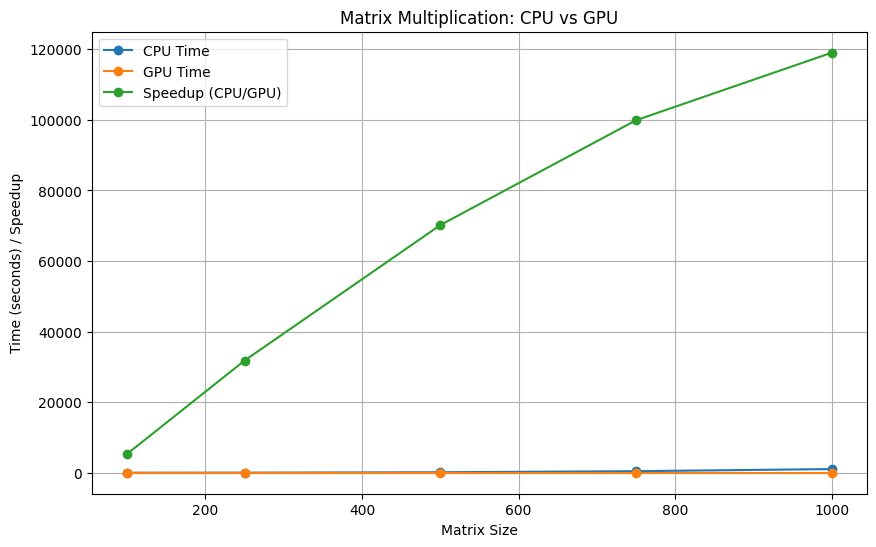

In [108]:
sizes = [100, 250, 500, 750, 1000] #calculating on colab (takes to much time for sizes > 1000)

cpu_times, gpu_times = run_experiments(sizes)

plot_results(sizes, cpu_times, gpu_times)